# 2025-04-07 Preconditioning & Domain decomposition

## Last time

* Krylov methods (focus on GMRES)

## Today

* Timetable for the rest of the semester
* Preconditioning building blocks
* Domain decomposition

In [2]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Timetable

* Comment on issue in community project (with link to your `proposal.md`) due today.
* Presentations on **Wednesday, 04/09** (day after tomorrow). Bring ~1-2 slides introducing the project you plan to contribute to.
* Feedback, then final proposals due **04/14**.
* As a reminder, PR submissions are due **04/28**, and you will present your contributions on **04/30**.

# Notes on GMRES

* **Recap**
    * Start with initial guess $x_0$ for solving $Ax = b$.
    * Look for improvements to $x_0$ in the Krylov space $\text{span} \{b, Ab, A^2b, \ldots, A^n b\}$.
    * At iteration $n$:
        * enlarge Krylov space by adding $A^n b$,
        * re-orthogonalize basis,
        * use least squares to find best improvement to add to $x_0$.
* $AQ_n = Q_{n+1}H_n$
* Then minimize $||Ax - b|| = \big|\big|H_n y - ||b||e_0\big|\big|$, where $x = Q_n y$ for some $y$.



* (How is the least squares problem solved? By incrementally updating a $QR$ factorization of $H_n$, $H_n = QR$, where $Q$ is orthogonal and $R$ is upper (right) triangular))
* The solution $x_n$ constructed by GMRES at iteration $n$ is not explicitly available -- it has to be constructed as $Q_n y$.
* The residual vector $r_n$ is also not explicitly available, and has to be built as $r_n = Ax_n - b$.
* Storing the full $Q_n$ is unaffordable for large $n$ (i.e. many iterations) $\to$ restart after $k$ iterations with initial guess $x_k$. This is called GMRES(k).
* Most implementations use classical Gram-Schmidt orthogonalization as a default instead of Arnoldi, because it's simple to implement (though numericall unstable). 

# (Simple) preconditioners

* The idea is that the preconditioned problem has a better condition number / more favourable spectrum (so that iterative methods converge faster)
* Reminder: choose matrix $P$ (or $T = P^{-1}$) and then solve
    * $AP^{-1}\underbrace{(Px)}_{y} = b$, then $Px = y$ (right-preconditioning), or
    * $P^{-1}(Ax - b) = 0$ (left-preconditioned)
* Preconditioned GMRES starts with an initial residual
$$ r = P^{-1}(b - Ax_0) $$
* **Question**: Based on the above, what would be the "ideal" preconditioner? 
    * Why can't we use this "ideal" preconditioner IRL?

* The "ideal" preconditioner would be $A^{-1}$, but it's not computable
* The "easiest" preconditioner is just $I$, but it doesn't do anything
* Preconditioners are in between those two extremes

## Jacobi 

* $$ P_{\text{Jacobi}}^{-1} = D^{-1}, $$ where $D$ is the diagonal of $A$.
* Good for diaonally dominant matrices

## Gauss-Seidel 

* $$ P_{GS}^{-1} = (L+D)^{-1}, $$ where $L$ is the (strictly) lower triangular part of $A$.  
* The upper triangular part may be used instead, or a symmetric form
$$ P_{SGS}^{-1} = (L+U)^{-1} A \Big( I - (L+D)^{-1} \Big) . $$

## Symmetric successive over-relaxation (SSOR)

* If $A$ can be written
$$ A = D + L + L^T, $$
* then
$$ P(\omega) = \frac{\omega}{2 - \omega}\left( \frac{1}{\omega} D + L \right) D^{-1} \left( \frac{1}{\omega} D + L \right)^T $$
* default $\omega = 1$

# Lanczos iteration: like GMRES for symmetric problems

* If $A$ is symmetric, then $H = Q^{T}AQ$ is also symmetric.
* Since $H$ is Hessenberg, this means $H$ is tridiagonal.
* Then instead of storing $Q_n$, it is sufficient to store only the last two columns since the iteration satisfies a 3-term recurrence.
* The analog of GMRES for the symmetric case is called MINRES and is also useful for solving symmetric indefinite problems.

# Domain decomposition

![](https://upload.wikimedia.org/wikipedia/commons/a/a9/Ddm_original_logo.png)

## [Alternating Schwarz method](https://en.wikipedia.org/wiki/Schwarz_alternating_method)

* Solve Laplace's equation on a domain made of an overlapping circle and rectangle, with Dirichlet boundary conditions.

```python
bc_circ = guess()
while not converged:
    u_circ = solve(A_circ, bc_circ)
    bc_rect = eval(u_circ, rect)
    u_rect = solve(A_rect, bc_rect)
    bc_circ = eval(u_rect, circ)
```

This method was proposed in 1870 by [Hermann Schwarz](https://en.wikipedia.org/wiki/Hermann_Schwarz) as a theoretical tool, and is now called a **multiplicative** Schwarz method because the solves depend on each other.  We can see it as a generalization of Gauss-Seidel in which we solve on subdomains instead of at individual grid points.  As with Gauss-Seidel, it is difficult to expose parallelism.

# Additive Schwarz

The additive Schwarz method is more comparable to Jacobi, with each domain solved in parallel.  Our fundamental operation will be an embedding of each subdomain $V_i$ into the global domain $V$, which we call the **prolongation**

$$ P_i : V_i \to V $$

The transpose of prolongation, $P_i^T$, will sometimes be called **restriction**.
Let's work an example.

In [13]:
n = 21
x = LinRange(-1, 1, n)
overlap = 0
domains = [(1, n÷3), (n÷3+1, 2*n÷3), (2*n÷3+1, n)]
Id = diagm(ones(n))
P = []
for (i, (left, right)) in enumerate(domains)
    push!(P, Id[:, left:right])
end

#print(P)
#print(size(P))

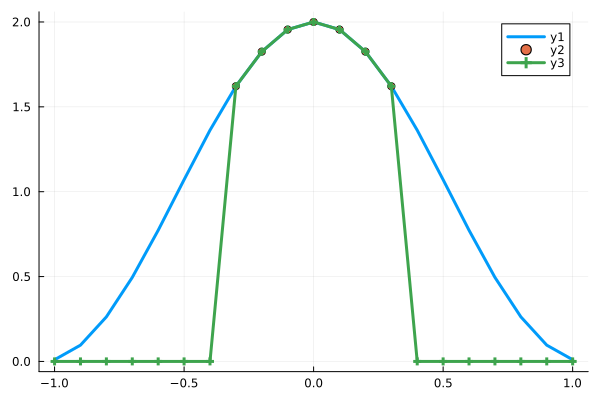

In [4]:
u = 1 .+ cos.(3*x)
plot(x, u)
u_2 = P[2]' * u
scatter!(P[2]' * x, u_2)
plot!(x, P[2] * u_2, marker=:auto)

# The algorithm

Define the subdomain operator $$A_i = P_i^T A P_i$$
The additive Schwarz preconditioner is
$$ M^{-1} = \sum_i P_i A_i^{-1} P_i^T $$
and it has error iteration matrix
$$ I - \sum_i  P_i A_i^{-1} P_i^T A $$

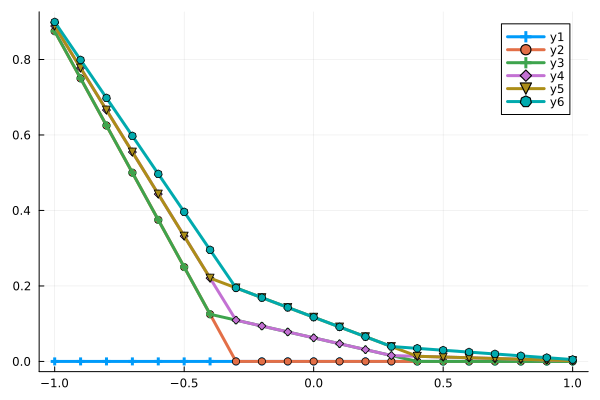

In [5]:
A = diagm(0 => 2*ones(n), -1 => -ones(n-1), 1 => -ones(n-1))
b = zeros(n); b[1] = 1
u = zero(b) # initial guess
us = [u]
for _ in 1:5
    r = b - A * u # residual
    u_next = copy(u);
    for Pi in P
        Ai = Pi' * A * Pi
        ui = Ai \ (Pi' * r)
        u_next += Pi * ui
    end
    u = u_next; push!(us, u)
end
plot(x, us, marker=:auto)

# Theory
Given a linear operator $A : V \to V$, suppose we have a collection of prolongation operators $P_i : V_i \to V$.  The columns of $P_i$ are "basis functions" for the subspace $V_i$.  The Galerkin operator $A_i = P_i^T A P_i$ is the action of the original operator $A$ in the subspace.

Define the subspace projection

$$ S_i = P_i A_i^{-1} P_i^T A . $$

* $S_i$ is a projector: $S_i^2 = S_i$
* If $A$ is SPD, $S_i$ is SPD with respect to the $A$ inner product $x^T A x$
* $I - S_i$ is $A$-orthogonal to the range of $P_i$

In [6]:
A2 = P[2]' * A * P[2]
S2 = P[2] * inv(A2) * P[2]' * A
norm(S2^2 - S2)

1.2036131040197588e-15

In [7]:
norm(P[2]' * A * (I - S2))

1.1831170202396054e-15

# Convergence theory

The formal convergence is beyond the scope of this course, but the following estimates are useful.  We let $h$ be the element diameter, $H$ be the subdomain diameter, and $\delta$ be the overlap, each normalized such that the global domain diameter is 1.  We express the convergence in terms of the condition number $\kappa$ for the preconditioned operator.

* (Block) Jacobi: $\delta=0$, $\kappa \sim H^{-2} H/h = (Hh)^{-1}$
* Overlapping Schwarz: $\kappa \sim H^{-2} H/\delta = (H \delta)^{-1}$
* 2-level overlapping Schwarz: $\kappa \sim H/\delta$

* Additive $ I - \sum_{i=0}^n S_i, $

* Multiplicative $ \prod_{i=0}^n (I - S_i), $
* Hybrid $ (I - S_0) (I - \sum_{i=1}^n S_i) . $

In each case above, the action is expressed in terms of the error iteration operator.